<a href="https://colab.research.google.com/github/Deleon57/EDAB6808/blob/main/Deleon_DAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core Bayesian Network library
!pip install bnlearn

# Data handling
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import networkx as nx

# Metrics and model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.4/190.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 6.5 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659682 sha256=57626b5ded42b2c8d4ac8e33c7166a9aff8ff073d9d46ee2f85e6f6f8ddd9c3e
  Stored in directory: /root/.cache/pip/wheels/c6/24/8b/be911b059a61f490f38425eb19bf2fed470a5ead97228e8255
Successfully built semopy


In [2]:
# --- Step 1: Load dataset ---
import pandas as pd

file_path = "/content/Subsistence Retail Consumer Data.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# --- Step 2: Collapse constructs into means (and round to nearest integer) ---

df_new = pd.DataFrame()

# Demographics (keep as is)
df_new["Gender"] = df["Gender A1"]
df_new["MaritalStatus"] = df["Marital Status A2"]
df_new["Age"] = df["Age A3"]
df_new["Employment"] = df["Employment Status A4"]
df_new["Education"] = df["Level of Education A5"]
df_new["RegularCustomer"] = df["Regular Customer A6"]
df_new["ShoppingFrequency"] = df["Shopping frequency A7"]

# Measurement instruments collapsed & rounded (Likert 1–5)
df_new["E"]   = df[["E1","E2","E3","E4"]].mean(axis=1).round().astype(int)
df_new["C"]   = df[["C1","C2","C3"]].mean(axis=1).round().astype(int)
df_new["PS"]  = df[["PS1","PS2","PS3"]].mean(axis=1).round().astype(int)
df_new["PE"]  = df[["PE1","PE2","PE3","PE4","PE5","PE6"]].mean(axis=1).round().astype(int)
df_new["PPQ"] = df[["PPQ1","PPQ2","PPQ3","PPQ4"]].mean(axis=1).round().astype(int)
df_new["CT"]  = df[["CT1","CT2","CT3","CT4","CT5","CT6","CT7"]].mean(axis=1).round().astype(int)
df_new["PV"]  = df[["PV1","PV2","PV3"]].mean(axis=1).round().astype(int)

# Purchase intentions (targets)
df_new["PI1"] = df["PI1"]
df_new["PI2"] = df["PI2"]
df_new["PI3"] = df["PI3"]
df_new["PI4"] = df["PI4"]

# --- Step 3: Inspect new dataset ---
print(df_new.head())
print("Shape:", df_new.shape)



   Gender  MaritalStatus  Age  Employment  Education  RegularCustomer  \
0       3              1    4           1          4                2   
1       3              3    5           1          4                1   
2       2              2    4           2          2                2   
3       1              1    3           1          3                2   
4       3              1    2           2          2                2   

   ShoppingFrequency  E  C  PS  PE  PPQ  CT  PV  PI1  PI2  PI3  PI4  
0                  3  3  3   2   3    4   3   3    3    4    4    4  
1                  1  3  4   3   3    2   3   2    4    4    4    4  
2                  2  3  3   3   3    3   3   2    3    3    4    3  
3                  1  3  3   4   3    3   3   2    3    4    3    4  
4                  3  3  3   2   3    3   3   3    2    3    2    3  
Shape: (281, 18)


In [3]:
# Rename Regular Customer A6
df = df.rename(columns={'Regular Customer A6': 'Type of Customer'})

# Create aggregated features
df_transformed = pd.DataFrame()
df_transformed['Type of Customer'] = df['Type of Customer']
#df_transformed[['PI1','PI2','PI3','PI4']] = df[['PI1','PI2','PI3','PI4']]

# Averages of measurement instruments, then round to nearest integer
df_transformed['E']    = df[['E1','E2','E3','E4']].mean(axis=1).round()
df_transformed['C']    = df[['C1','C2','C3']].mean(axis=1).round()
df_transformed['PS']   = df[['PS1','PS2','PS3']].mean(axis=1).round()
df_transformed['PE']   = df[['PE1','PE2','PE3','PE4','PE5','PE6']].mean(axis=1).round()
df_transformed['PPQ']  = df[['PPQ1','PPQ2','PPQ3','PPQ4']].mean(axis=1).round()
df_transformed['CT']   = df[['CT1','CT2','CT3','CT4','CT5','CT6','CT7']].mean(axis=1).round()
df_transformed['PV']   = df[['PV1','PV2','PV3']].mean(axis=1).round()
df_transformed['PI']   = df[['PI1','PI2','PI3','PI4']].mean(axis=1).round()

print(df_transformed.head())
print(df_transformed.shape)

   Type of Customer    E    C   PS   PE  PPQ   CT   PV   PI
0                 2  3.0  3.0  2.0  3.0  4.0  3.0  3.0  4.0
1                 1  3.0  4.0  3.0  3.0  2.0  3.0  2.0  4.0
2                 2  3.0  3.0  3.0  3.0  3.0  3.0  2.0  3.0
3                 2  3.0  3.0  4.0  3.0  3.0  3.0  2.0  4.0
4                 2  3.0  3.0  2.0  3.0  3.0  3.0  3.0  2.0
(281, 9)


#Expert labelled Dag

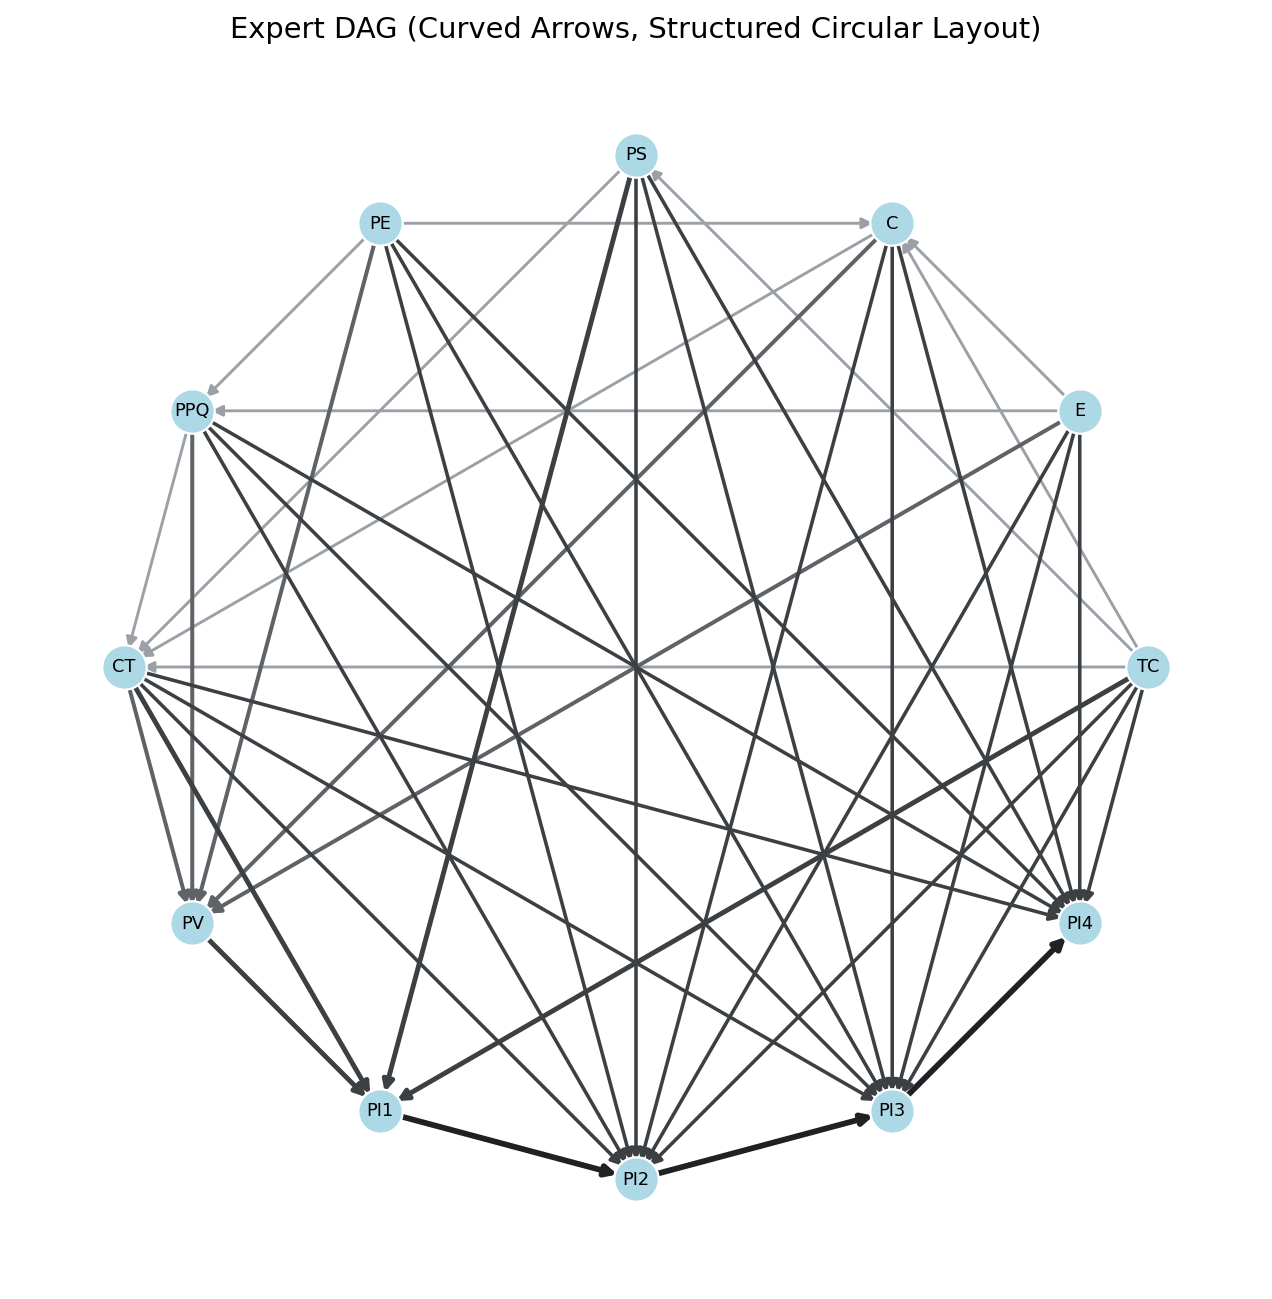

Total edges: 43
[('C', 'CT'), ('C', 'PI2'), ('C', 'PI3'), ('C', 'PI4'), ('C', 'PV'), ('CT', 'PI1'), ('CT', 'PI2'), ('CT', 'PI3'), ('CT', 'PI4'), ('CT', 'PV'), ('E', 'C'), ('E', 'PI2'), ('E', 'PI3'), ('E', 'PI4'), ('E', 'PPQ'), ('E', 'PV'), ('PE', 'C'), ('PE', 'PI2'), ('PE', 'PI3'), ('PE', 'PI4'), ('PE', 'PPQ'), ('PE', 'PV'), ('PI1', 'PI2'), ('PI2', 'PI3'), ('PI3', 'PI4'), ('PPQ', 'CT'), ('PPQ', 'PI2'), ('PPQ', 'PI3'), ('PPQ', 'PI4'), ('PPQ', 'PV'), ('PS', 'CT'), ('PS', 'PI1'), ('PS', 'PI2'), ('PS', 'PI3'), ('PS', 'PI4'), ('PV', 'PI1'), ('TC', 'C'), ('TC', 'CT'), ('TC', 'PI1'), ('TC', 'PI2'), ('TC', 'PI3'), ('TC', 'PI4'), ('TC', 'PS')]


In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# ----------------- CORE STRUCTURE (same as before) -----------------
edges_to_pi1 = [("TC","PI1"), ("PS","PI1"), ("CT","PI1"), ("PV","PI1")]
edges_to_pv  = [("PPQ","PV"), ("CT","PV"), ("E","PV"), ("C","PV"), ("PE","PV")]
pi_chain     = [("PI1","PI2"), ("PI2","PI3"), ("PI3","PI4")]

# Inter-feature links (no cycles; keep circular look)
feature_edges = [
    ("TC","PS"), ("TC","C"), ("TC","CT"),
    ("PE","C"),  ("PE","PPQ"),
    ("E","C"),   ("E","PPQ"),
    ("C","CT"),  ("PPQ","CT"),
    ("PS","CT"),
]

# ----------------- NEW: FEATURES → PI2/PI3/PI4 -----------------
# Rationale:
# - Repeat purchase (PI2) is pushed by trust, quality, convenience, environment, price stance, empathy, and shopper type.
# - Future purchase (PI3) is shaped by the same set (persistence of intention).
# - Recommendation (PI4) typically reflects trust/quality/convenience/experiential value and fair pricing.
features = ["CT","PPQ","PE","PS","C","E","TC"]
edges_to_pi2 = [(f, "PI2") for f in features]
edges_to_pi3 = [(f, "PI3") for f in features]
edges_to_pi4 = [(f, "PI4") for f in features]

# Combine all edges
all_edges = (
    feature_edges + edges_to_pv + edges_to_pi1 +
    pi_chain + edges_to_pi2 + edges_to_pi3 + edges_to_pi4
)

# ----------------- BUILD GRAPH -----------------
G = nx.DiGraph()
G.add_edges_from(all_edges)

# ----------------- KEEP THE SHAPE: fixed circular order -----------------
node_order = ["TC","E","C","PS","PE","PPQ","CT","PV","PI1","PI2","PI3","PI4"]
theta = np.linspace(0, 2*np.pi, len(node_order), endpoint=False)
pos = {n: (np.cos(t), np.sin(t)) for n, t in zip(node_order, theta)}

# ----------------- DRAW -----------------
plt.figure(figsize=(10,10), dpi=160)
plt.title("Expert DAG (Curved Arrows, Structured Circular Layout)", fontsize=13)

# Nodes + labels
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=400, edgecolors="white")
nx.draw_networkx_labels(G, pos, font_size=8)

# Helper to draw edge groups with clear arrows
def draw_edges(edgelist, color, width):
    nx.draw_networkx_edges(
        G, pos, edgelist=edgelist,
        arrows=True, arrowstyle='-|>', arrowsize=10,
        width=width, edge_color=color,
        connectionstyle="arc3,rad=0"  # curved (valid string; avoids the error)
    )

# Edge groups (slightly darker as we approach PI chain)
draw_edges(feature_edges, color="#9aa0a6", width=1.3)   # feature→feature
draw_edges(edges_to_pv,  color="#5f6368", width=1.8)    # → PV
draw_edges(edges_to_pi1, color="#3c4043", width=2.2)    # → PI1
draw_edges(pi_chain,     color="#202124", width=2.6)    # PI1→PI2→PI3→PI4
draw_edges(edges_to_pi2+edges_to_pi3+edges_to_pi4, color="#3c4043", width=1.6)  # features → PI2/3/4

plt.axis("equal"); plt.axis("off")
plt.show()

# Inspect edges if needed
print(f"Total edges: {len(G.edges())}")
print(sorted(G.edges()))
